# Plot and restore all dvv traces with threshold
2022.11.02 Kurama Okubo

This notebook plots all dvv traces from hdf5 with the channel weighting, and apply the threshold of the data continuity to fit the model.

The threshold applied through this process is:

1. data contents over all study period (2002-2022) > 0.7 

- 2023.06.30 update for count the excluded station pairs.

In [36]:
import datetime
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates
%matplotlib inline

import numpy as np
import pandas as pd
import h5py

import shutil
from tqdm import tqdm

from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib as mpl

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

In [37]:
#---Constants---#
data_contents_min = 0.7 # threshold of data contents
# data_fitcontents_min = 0.7 # deprecated: threshold on data fitting 

In [38]:
#---set the file path of your case study list---#
root = "../processed_data/"
h5_stats_list = [
                  root+"/dvvtraces_chanweighted_monitoring_stats_uwbackup_2010-2022_stretching.csv_0.9-1.2.h5",
                  root+"/dvvtraces_chanweighted_monitoring_stats_uwbackup_2010-2022_mwcs.csv_0.9-1.2.h5"]

starttime = datetime.datetime(2002, 1, 1)
endtime = datetime.datetime(2022, 6, 1)

vlines = [datetime.datetime(2003, 12, 22), datetime.datetime(2004, 9, 28)] 

h5_id = 1

output_imgdir_root = "../figure/plotfromh5_chanweight"
output_datadir = "../processed_data"
image_format="png"
dpi = 150
show=True
#-------------------------------------------#

if not os.path.exists(output_imgdir_root):
    os.makedirs(output_imgdir_root)
    
if not os.path.exists(output_datadir):
    os.makedirs(output_datadir)

In [39]:
casename = os.path.basename(h5_stats_list[h5_id].split('.h5')[0])

freqband = h5_stats_list[h5_id].split('.h5')[0].split('_')[-1]
freqband

'0.9-1.2'

In [40]:
dvvmethod = casename.split('.csv')[0].split('_')[-1]
dvvmethod

'mwcs'

In [41]:
output_imgdir = os.path.join(output_imgdir_root, dvvmethod, freqband)
if not os.path.exists(output_imgdir):
    os.makedirs(output_imgdir)

# Compute mean and std from hdf5 time series

In [42]:
fi = h5py.File(h5_stats_list[h5_id], "r")

In [43]:
uniform_tvec = np.array(fi['uniform_tvec'])

In [44]:
stationpairs = list(fi['dvv'].keys())

In [45]:
df_meanstd_all = pd.DataFrame(uniform_tvec, columns = ['tvec'])
df_err_all = pd.DataFrame(uniform_tvec, columns = ['tvec'])
df_markercolor_all = pd.DataFrame(uniform_tvec, columns = ['tvec'])

for sta in stationpairs:
#     print(sta)
    datacontents = float(np.array(fi['dvv/{}/datacontents'.format(sta)]))
    fitcontents = float(np.array(fi['dvv/{}/fitcontents'.format(sta)]))
    t_unix = np.array(fi['dvv/{}/t_unix'.format(sta)])
    dvv_tmp = np.array(fi['dvv/{}/dvv'.format(sta)])
    err_tmp = np.array(fi['dvv/{}/err'.format(sta)])
    
    # threshold 1: check datacontents
    if (datacontents > data_contents_min): #& (fitcontents > data_fitcontents_min):
        
        data = {'tvec': t_unix, sta: dvv_tmp}
        df_trace = pd.DataFrame.from_dict(data)
        # left outer join
        df_meanstd_all = pd.merge(df_meanstd_all, df_trace, on='tvec', how='left')

        if dvvmethod == "stretching":
            cc_tmp = np.array(fi['dvv/{}/cc'.format(sta)])
            cc_data = {'tvec': t_unix, sta: cc_tmp}
            df_trace_cc = pd.DataFrame.from_dict(cc_data)
            # left outer join
            df_markercolor_all = pd.merge(df_markercolor_all, df_trace_cc, on='tvec', how='left')
    
            # make dataframe for error
            data = {'tvec': t_unix, sta: err_tmp}
            df_err = pd.DataFrame.from_dict(data)
            df_err_all = pd.merge(df_err_all, df_err, on='tvec', how='left')
            
        elif dvvmethod == "mwcs":
            cc_tmp = np.array(fi['dvv/{}/cc'.format(sta)])
            cc_data = {'tvec': t_unix, sta: cc_tmp}
            df_trace_cc = pd.DataFrame.from_dict(cc_data)

            # make dataframe for error
            data = {'tvec': t_unix, sta: err_tmp}
            df_err = pd.DataFrame.from_dict(data)
            df_err_all = pd.merge(df_err_all, df_err, on='tvec', how='left')
            
            err_tmp = np.array(fi['dvv/{}/err'.format(sta)])
            err_data = {'tvec': t_unix, sta: err_tmp}
            df_trace_err = pd.DataFrame.from_dict(err_data)

            #left outer join
            df_markercolor_all = pd.merge(df_markercolor_all, df_trace_err, on='tvec', how='left')
    
    else:
        #data contents is not enough. skipping
        continue

df_meanstd_all = df_meanstd_all.set_index('tvec')
df_err_all = df_err_all.set_index('tvec')
df_markercolor_all = df_markercolor_all.set_index('tvec')

In [46]:
# Compute how many station pairs are threshold out by the fraction of data contents.
print(f"We use {len(df_meanstd_all.columns)} from {len(stationpairs)} station pairs. Thus, we excluded {len(stationpairs) - len(df_meanstd_all.columns)} paris for the case with {dvvmethod}.")

We use 56 from 83 station pairs. Thus, we excluded 27 paris for the case with mwcs.


In [47]:
df_meanstd_all.head()
df_err_all.head()

,BP.CCRB-BP.CCRB,BP.CCRB-BP.EADB,BP.CCRB-BP.JCSB,BP.CCRB-BP.LCCB,BP.CCRB-BP.MMNB,BP.CCRB-BP.SCYB,BP.CCRB-BP.SMNB,BP.CCRB-BP.VCAB,BP.EADB-BP.EADB,BP.EADB-BP.FROB,...,BP.MMNB-BP.SMNB,BP.MMNB-BP.VCAB,BP.SCYB-BP.SCYB,BP.SCYB-BP.SMNB,BP.SCYB-BP.VCAB,BP.SMNB-BP.SMNB,BP.SMNB-BP.VARB,BP.SMNB-BP.VCAB,BP.VARB-BP.VARB,BP.VCAB-BP.VCAB
tvec,,,,,,,,,,,,,,,,,,,,,
1011139200,NaN,0.000176,NaN,NaN,NaN,NaN,NaN,NaN,0.000026,0.000049,...,0.000033,0.000038,0.000040,0.000026,0.000015,0.000027,0.000030,0.000022,0.000043,0.000005
1012435200,NaN,NaN,0.00020,NaN,NaN,NaN,NaN,NaN,0.000033,0.000078,...,0.000046,0.000022,0.000049,0.000033,0.000041,0.000022,0.000033,0.000034,0.000032,0.000003
1013731200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000035,0.000128,...,0.000066,0.000046,NaN,NaN,NaN,0.000020,0.000044,0.000016,0.000027,0.000006
1015027200,NaN,0.000175,NaN,NaN,NaN,NaN,NaN,0.000173,0.000029,0.000104,...,0.000062,0.000030,NaN,NaN,NaN,0.000014,0.000059,0.000023,0.000029,0.000003
1016323200,NaN,NaN,0.00006,NaN,NaN,NaN,NaN,NaN,0.000033,0.000104,...,0.000058,0.000026,NaN,0.000040,0.000062,0.000023,0.000024,0.000016,0.000026,0.000004


In [48]:
df_markercolor_all

,BP.CCRB-BP.CCRB,BP.CCRB-BP.EADB,BP.CCRB-BP.JCSB,BP.CCRB-BP.LCCB,BP.CCRB-BP.MMNB,BP.CCRB-BP.SCYB,BP.CCRB-BP.SMNB,BP.CCRB-BP.VCAB,BP.EADB-BP.EADB,BP.EADB-BP.FROB,...,BP.MMNB-BP.SMNB,BP.MMNB-BP.VCAB,BP.SCYB-BP.SCYB,BP.SCYB-BP.SMNB,BP.SCYB-BP.VCAB,BP.SMNB-BP.SMNB,BP.SMNB-BP.VARB,BP.SMNB-BP.VCAB,BP.VARB-BP.VARB,BP.VCAB-BP.VCAB
tvec,,,,,,,,,,,,,,,,,,,,,
1011139200,NaN,0.000176,NaN,NaN,NaN,NaN,NaN,NaN,0.000026,0.000049,...,0.000033,0.000038,0.000040,0.000026,0.000015,0.000027,0.000030,0.000022,0.000043,0.000005
1012435200,NaN,NaN,0.000200,NaN,NaN,NaN,NaN,NaN,0.000033,0.000078,...,0.000046,0.000022,0.000049,0.000033,0.000041,0.000022,0.000033,0.000034,0.000032,0.000003
1013731200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000035,0.000128,...,0.000066,0.000046,NaN,NaN,NaN,0.000020,0.000044,0.000016,0.000027,0.000006
1015027200,NaN,0.000175,NaN,NaN,NaN,NaN,NaN,0.000173,0.000029,0.000104,...,0.000062,0.000030,NaN,NaN,NaN,0.000014,0.000059,0.000023,0.000029,0.000003
1016323200,NaN,NaN,0.000060,NaN,NaN,NaN,NaN,NaN,0.000033,0.000104,...,0.000058,0.000026,NaN,0.000040,0.000062,0.000023,0.000024,0.000016,0.000026,0.000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648771200,0.000002,NaN,0.000183,NaN,NaN,NaN,NaN,NaN,0.000006,0.000037,...,0.000011,0.000005,0.000004,0.000012,0.000008,0.000004,NaN,0.000011,NaN,0.000001
1650067200,0.000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000003,0.000033,...,0.000007,0.000006,0.000005,0.000010,0.000005,0.000004,NaN,0.000007,0.000169,0.000002
1651363200,0.000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000006,0.000053,...,0.000011,0.000008,0.000006,0.000008,0.000008,0.000005,NaN,0.000014,0.000169,0.000002


In [49]:
dvv_mean = df_meanstd_all.mean(axis=1, skipna=True)
dvv_median = df_meanstd_all.median(axis=1, skipna=True)
dvv_std  = df_meanstd_all.std(axis=1, skipna=True)

In [50]:
gcm = plt.get_cmap("viridis")
df_meanstd_all

,BP.CCRB-BP.CCRB,BP.CCRB-BP.EADB,BP.CCRB-BP.JCSB,BP.CCRB-BP.LCCB,BP.CCRB-BP.MMNB,BP.CCRB-BP.SCYB,BP.CCRB-BP.SMNB,BP.CCRB-BP.VCAB,BP.EADB-BP.EADB,BP.EADB-BP.FROB,...,BP.MMNB-BP.SMNB,BP.MMNB-BP.VCAB,BP.SCYB-BP.SCYB,BP.SCYB-BP.SMNB,BP.SCYB-BP.VCAB,BP.SMNB-BP.SMNB,BP.SMNB-BP.VARB,BP.SMNB-BP.VCAB,BP.VARB-BP.VARB,BP.VCAB-BP.VCAB
tvec,,,,,,,,,,,,,,,,,,,,,
1011139200,NaN,0.162079,NaN,NaN,NaN,NaN,NaN,NaN,-0.010228,0.023255,...,-0.051931,-0.078795,0.032702,-0.023923,-0.052801,-0.019744,-0.005060,-0.080735,-0.019462,-0.006828
1012435200,NaN,NaN,0.021666,NaN,NaN,NaN,NaN,NaN,-0.103807,0.101199,...,0.021363,-0.068585,-0.009110,0.013896,0.017864,-0.053443,-0.006618,-0.041994,-0.028851,-0.012517
1013731200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.100301,0.105676,...,0.061695,-0.042908,NaN,NaN,NaN,-0.105666,-0.004516,-0.020550,-0.023816,-0.029207
1015027200,NaN,-1.226687,NaN,NaN,NaN,NaN,NaN,0.407064,-0.114802,0.123143,...,0.067379,-0.048763,NaN,NaN,NaN,-0.037893,-0.028980,-0.037316,-0.018699,-0.047641
1016323200,NaN,NaN,-0.083098,NaN,NaN,NaN,NaN,NaN,-0.035036,0.020370,...,-0.055299,-0.041443,NaN,0.012145,-0.090885,-0.103111,0.021084,-0.047757,-0.020490,-0.050960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648771200,0.010472,NaN,1.055814,NaN,NaN,NaN,NaN,NaN,0.028994,-0.013485,...,0.002792,0.011879,0.045001,0.033524,0.031078,0.024460,NaN,0.053126,NaN,0.036432
1650067200,0.017059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019493,-0.010858,...,0.016970,0.031808,0.031857,0.051069,0.007794,0.043154,NaN,0.039799,-0.578488,0.054801
1651363200,0.025492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022234,0.103311,...,0.006618,0.016606,-0.016997,0.030223,0.022051,0.034862,NaN,0.023794,-0.578488,0.037922


## Plot mean dv/v time history

In [51]:
dvvmethod

'mwcs'

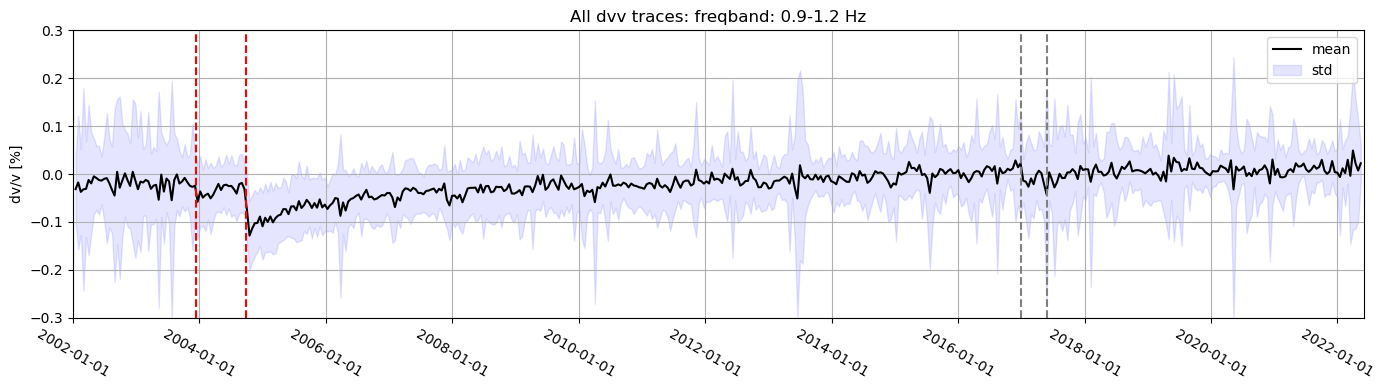

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(14,4))

uniform_tvec = [datetime.datetime.utcfromtimestamp(x) for x in df_meanstd_all.index]

#----------------------------------------#
# Plot all station pair traces
#----------------------------------------#

# Plot for stretching
# if dvvmethod=='stretching':

#     gcm = plt.get_cmap("Greys")
    
#     vmin, vmax = 0.9, 1.0
#     normalize = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    
#     for col in df_meanstd_all:
#         mc = df_markercolor_all[col]
#         ax.scatter(uniform_tvec, df_meanstd_all[col].values, s=30, alpha=1.0, c=mc, norm=normalize, cmap=gcm) #alpha=0.05
        
#     cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=gcm),
#                  orientation='vertical',
#                  label="CC")

# Plot for mwcs
# elif dvvmethod=='mwcs':
    
#     gcm = plt.get_cmap("Greys")
#     vmin, vmax = 1e-5, 2e-4
#     normalize = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    
#     for col in df_meanstd_all:
#         mc = df_markercolor_all[col]
#         ax.scatter(uniform_tvec, df_meanstd_all[col].values, s=30, alpha=1.0, c=mc, norm=normalize, cmap=gcm) #alpha=0.05
        
#     cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=gcm),
#                  orientation='vertical',
#                  label="err mwcs")
    
ax.plot(uniform_tvec, dvv_mean, 'k-', label="mean")
# ax.plot(uniform_tvec, dvv_median, 'b-', label="median")

yerr1 = np.array(dvv_mean) - np.array(dvv_std)
yerr2 = np.array(dvv_mean) + np.array(dvv_std)
ax.fill_between(uniform_tvec, yerr1, yerr2,
                 color='b', alpha=0.1, label="std")

for vline in vlines:
    ax.axvline(vline,
                color='r',
                linewidth=1.5,
                linestyle='--',
                zorder=2)

#period of unstable dv/v
vlines_unstable = [datetime.datetime(2017, 1, 1), datetime.datetime(2017, 6, 1)] 
for vline in vlines_unstable:
    ax.axvline(vline,
                color='gray',
                linewidth=1.5,
                linestyle='--',
                zorder=2)

# ax.text(datetime.datetime(2012, 6, 10), 0.2, "2017/1/1 - 2017/6/1", fontsize=16)


#     ax.set_ylim(-0.005, 0.005)
ax.set_xlim(starttime, endtime)
ax.set_ylim(-0.3, 0.3)
ax.set_title("All dvv traces: freqband: %s Hz"%(freqband))
# ax.set_title("All dvv traces: freqband: %s Hz"%("0.9-1.2"))
ax.grid(True)
ax.legend()
xfmt = dates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)
ax.set_ylabel("dv/v [%]")
plt.setp(ax.xaxis.get_majorticklabels(), rotation=-30)
plt.tight_layout()
foname = (output_imgdir+"/all_dvv_thresholded_%s.png"%(casename))
plt.savefig(foname)

## Remove the outliers for the model fit
The measurement of dv/v is sometimes unstable, showing unusually large magnitude. While we need to investigate the cause of such outliers in the measurement, e.g. cycle skipping, those outliers are inpractical to fit the model. To mitigate the artifacts of the outliers on the model fitting, we threshold out the dv/v measurement more than 0.3% change.

In [53]:
outlier_threshold = 0.3 # [%]; this is unrealistic in the change of velocity, which would perturve the model fitting

In [54]:
uniform_tvec_unix = np.array(fi['uniform_tvec'])

df_meanstd_all_maxthreshold = pd.DataFrame(uniform_tvec_unix, columns = ['tvec'])
df_err_all_maxthreshold = pd.DataFrame(uniform_tvec_unix, columns = ['tvec'])
   
for stationpair_thredsholded in tqdm(df_meanstd_all.keys()):
    df_meanstd_thresholded_pair = df_meanstd_all[stationpair_thredsholded]
    df_err_thresholded_pair = df_err_all[stationpair_thredsholded]
    
    # ---threshold out with the maximum magnitude----#
    print(np.max(np.abs(df_meanstd_thresholded_pair)))
    
    df_meanstd_thresholded_pair = df_meanstd_thresholded_pair.mask(np.abs(df_meanstd_thresholded_pair) > outlier_threshold)
    df_err_thresholded_pair = df_err_thresholded_pair.mask(np.array(np.abs(df_meanstd_thresholded_pair) > outlier_threshold))
    #---------------------------------------------------------------#
    
    dvv_raw = np.array(df_meanstd_thresholded_pair)
    
    err = np.array(df_err_thresholded_pair)
    
    # save data to dataframe
    data = {'tvec': df_meanstd_thresholded_pair.index, stationpair_thredsholded: dvv_raw}
    df_trace_raw= pd.DataFrame.from_dict(data)
    # left outer join
    df_meanstd_all_maxthreshold = pd.merge(df_meanstd_all_maxthreshold, df_trace_raw, on='tvec', how='left')
    
    # store error data
    data_err = {'tvec': df_err_thresholded_pair.index, stationpair_thredsholded: err}
    df_err_tmp = pd.DataFrame.from_dict(data_err)
    # left outer join
    df_err_all_maxthreshold = pd.merge(df_err_all_maxthreshold, df_err_tmp, on='tvec', how='left')
    

    tvec = [datetime.datetime.utcfromtimestamp(x) for x in df_meanstd_thresholded_pair.index]

    fig, ax = plt.subplots(1, 1, figsize=(8,3))
    ax.errorbar(tvec, dvv_raw, yerr = err, capsize=3, ls="-", c = "r", ecolor='black')
    ax.set_xlim(starttime, endtime)
    ax.set_ylim(-0.3, 0.3)
    ax.set_title("dvv traces: %s freqband: %s Hz"%(stationpair_thredsholded,freqband))
    ax.grid(True)
#     ax.legend()
    ax.set_ylabel("dv/v [%]")

    xfmt = dates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(xfmt)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=-30)
    plt.tight_layout()
    foname = (output_imgdir+"/dvv_trace_%s_%s_%s.png"%(dvvmethod, freqband, stationpair_thredsholded))
    plt.savefig(foname, dpi=150)
    plt.close('all')

  2%|█▌                                                                                       | 1/56 [00:00<00:08,  6.67it/s]

0.26646263698438866
1.2266865959013338


  5%|████▊                                                                                    | 3/56 [00:00<00:08,  6.35it/s]

1.2933126315691905
0.15356988657704856


  9%|███████▉                                                                                 | 5/56 [00:00<00:08,  6.21it/s]

0.6867578362778292
0.21357767515629522


 12%|███████████▏                                                                             | 7/56 [00:01<00:07,  6.17it/s]

0.4938334135546467
1.2178303398972175


 16%|██████████████▎                                                                          | 9/56 [00:01<00:07,  6.23it/s]

0.5040604426358414
1.3402687846556602


 20%|█████████████████▎                                                                      | 11/56 [00:01<00:07,  5.70it/s]

0.9881866100356412
0.5375803596555819


 23%|████████████████████▍                                                                   | 13/56 [00:02<00:07,  5.77it/s]

0.2875751216875866
0.1873831981237258


 27%|███████████████████████▌                                                                | 15/56 [00:02<00:06,  5.98it/s]

0.30814216544531153
0.26955459336607746


 30%|██████████████████████████▋                                                             | 17/56 [00:02<00:06,  6.23it/s]

0.25604726534754674
1.5680000999431305


 34%|█████████████████████████████▊                                                          | 19/56 [00:03<00:06,  5.62it/s]

0.34930416659979535
0.7717744235251602


 38%|█████████████████████████████████                                                       | 21/56 [00:03<00:05,  6.15it/s]

1.4162218864127396
0.6766694953856534


 41%|████████████████████████████████████▏                                                   | 23/56 [00:03<00:05,  6.52it/s]

0.5815898870883411
0.7681637734401232


 45%|███████████████████████████████████████▎                                                | 25/56 [00:04<00:04,  6.60it/s]

0.46441402086709394
0.9788411295514601


 48%|██████████████████████████████████████████▍                                             | 27/56 [00:04<00:04,  6.74it/s]

1.4747087653794846
0.5374336049371341


 52%|█████████████████████████████████████████████▌                                          | 29/56 [00:04<00:03,  6.87it/s]

0.6424126177120056
0.6341200201063514


 55%|████████████████████████████████████████████████▋                                       | 31/56 [00:05<00:03,  6.25it/s]

0.8697913377517614
0.500498526835983


 59%|███████████████████████████████████████████████████▊                                    | 33/56 [00:05<00:03,  6.36it/s]

0.7260554062876701
0.5215595505753368


 62%|███████████████████████████████████████████████████████                                 | 35/56 [00:05<00:03,  6.64it/s]

1.2315427965892234
1.172274543248628


 66%|██████████████████████████████████████████████████████████▏                             | 37/56 [00:05<00:02,  6.70it/s]

1.1068816033012903
0.5619242618717676


 70%|█████████████████████████████████████████████████████████████▎                          | 39/56 [00:06<00:02,  6.77it/s]

0.3227112914155132
1.2695137158342649


 73%|████████████████████████████████████████████████████████████████▍                       | 41/56 [00:06<00:02,  6.78it/s]

0.22869583666316184
0.1782181238730335


 75%|██████████████████████████████████████████████████████████████████                      | 42/56 [00:06<00:02,  6.83it/s]

0.769916664767635


 79%|█████████████████████████████████████████████████████████████████████▏                  | 44/56 [00:07<00:02,  5.32it/s]

0.5899058566499695
0.6831258778838001


 82%|████████████████████████████████████████████████████████████████████████▎               | 46/56 [00:07<00:01,  5.75it/s]

0.33494808134613707
0.23246484531044243


 86%|███████████████████████████████████████████████████████████████████████████▍            | 48/56 [00:07<00:01,  6.22it/s]

1.604650475519887
0.35288152211965435


 89%|██████████████████████████████████████████████████████████████████████████████▌         | 50/56 [00:08<00:00,  6.48it/s]

0.14885072128662893
0.5466025108565165


 93%|█████████████████████████████████████████████████████████████████████████████████▋      | 52/56 [00:08<00:00,  6.46it/s]

0.20918018269964708
0.7792898597803749


 96%|████████████████████████████████████████████████████████████████████████████████████▊   | 54/56 [00:08<00:00,  6.67it/s]

0.2871561189627821
1.9191806292214766


100%|████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:08<00:00,  6.24it/s]

0.2004724922549022


In [55]:
df_err_thresholded_pair.mask(np.array(np.abs(df_meanstd_thresholded_pair) > outlier_threshold))

tvec
1011139200    0.000005
1012435200    0.000003
1013731200    0.000006
1015027200    0.000003
1016323200    0.000004
                ...   
1648771200    0.000001
1650067200    0.000002
1651363200    0.000002
1652659200    0.000002
1653955200         NaN
Name: BP.VCAB-BP.VCAB, Length: 497, dtype: float64

# Check the dv/v traces after thresholding the outliers

In [56]:
df_meanstd_all_maxthreshold

,tvec,BP.CCRB-BP.CCRB,BP.CCRB-BP.EADB,BP.CCRB-BP.JCSB,BP.CCRB-BP.LCCB,BP.CCRB-BP.MMNB,BP.CCRB-BP.SCYB,BP.CCRB-BP.SMNB,BP.CCRB-BP.VCAB,BP.EADB-BP.EADB,...,BP.MMNB-BP.SMNB,BP.MMNB-BP.VCAB,BP.SCYB-BP.SCYB,BP.SCYB-BP.SMNB,BP.SCYB-BP.VCAB,BP.SMNB-BP.SMNB,BP.SMNB-BP.VARB,BP.SMNB-BP.VCAB,BP.VARB-BP.VARB,BP.VCAB-BP.VCAB
0,1011139200,NaN,0.162079,NaN,NaN,NaN,NaN,NaN,NaN,-0.010228,...,-0.051931,-0.078795,0.032702,-0.023923,-0.052801,-0.019744,-0.005060,-0.080735,-0.019462,-0.006828
1,1012435200,NaN,NaN,0.021666,NaN,NaN,NaN,NaN,NaN,-0.103807,...,0.021363,-0.068585,-0.009110,0.013896,0.017864,-0.053443,-0.006618,-0.041994,-0.028851,-0.012517
2,1013731200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.100301,...,0.061695,-0.042908,NaN,NaN,NaN,-0.105666,-0.004516,-0.020550,-0.023816,-0.029207
3,1015027200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.114802,...,0.067379,-0.048763,NaN,NaN,NaN,-0.037893,-0.028980,-0.037316,-0.018699,-0.047641
4,1016323200,NaN,NaN,-0.083098,NaN,NaN,NaN,NaN,NaN,-0.035036,...,-0.055299,-0.041443,NaN,0.012145,-0.090885,-0.103111,0.021084,-0.047757,-0.020490,-0.050960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,1648771200,0.010472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028994,...,0.002792,0.011879,0.045001,0.033524,0.031078,0.024460,NaN,0.053126,NaN,0.036432
493,1650067200,0.017059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019493,...,0.016970,0.031808,0.031857,0.051069,0.007794,0.043154,NaN,0.039799,NaN,0.054801
494,1651363200,0.025492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022234,...,0.006618,0.016606,-0.016997,0.030223,0.022051,0.034862,NaN,0.023794,NaN,0.037922
495,1652659200,-0.000020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.040613,...,0.012406,0.028040,-0.009773,0.002807,0.008446,0.004997,NaN,0.044062,NaN,0.046758


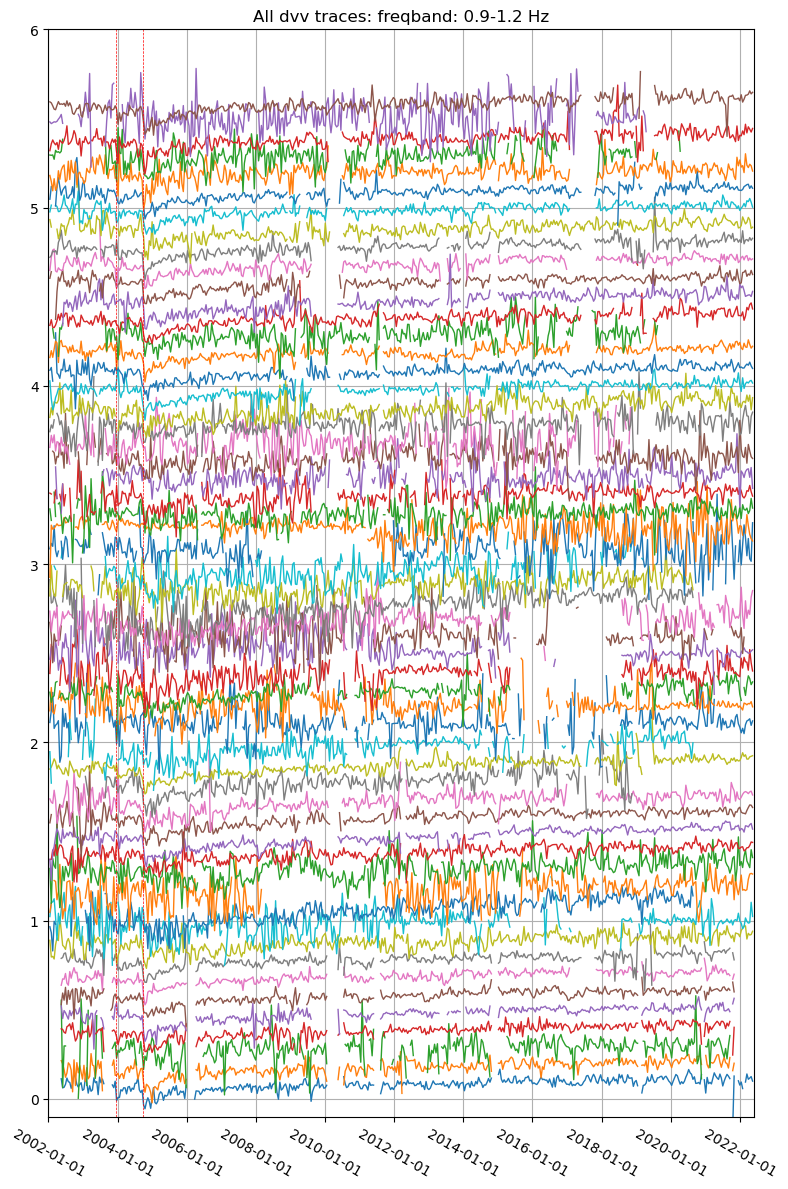

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(8,12))
uniform_tvec = [datetime.datetime.utcfromtimestamp(x) for x in df_meanstd_all.index]
colors = plt.cm.jet(np.linspace(0,1,df_meanstd_all.shape[1]))

# Plot all station pair traces
yshift = 0;
yinc = 0.1;
for i, col in enumerate(df_meanstd_all_maxthreshold):
    if col=="tvec":
        continue
        
    yshift = yshift + yinc
    ax.plot(uniform_tvec, df_meanstd_all_maxthreshold[col]+yshift, '-', lw=1.0)
    
for vline in vlines:
    ax.axvline(vline,
                color='r',
                linewidth=0.5,
                linestyle='--',
                zorder=2)

ax.set_xlim(starttime, endtime)
ax.set_ylim(-0.1, 6)
ax.set_title("All dvv traces: freqband: %s Hz"%(freqband))
ax.grid(True)
xfmt = dates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=-30)
plt.tight_layout()
foname = (output_imgdir+"/traces_dvv_thresholded_%s.png"%(casename))
plt.savefig(foname)


# Save traces 

In [58]:
np.array(df_meanstd_all_maxthreshold['BP.CCRB-BP.SCYB'])

array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
       -6.98878098e-02, -5.83380008e-03, -4.59239304e-02,  2.60267445e-02,
       -6.90429906e-02,  8.74803525e-03, -4.13937340e-02,  9.79726279e-04,
        1.64495127e-02, -1.51397458e-01,  1.90837338e-02,  1.47531056e-02,
       -5.81350141e-02, -5.11603775e-02,  2.52732936e-02, -2.24668264e-02,
        1.05391908e-02, -6.38736893e-03, -4.18554217e-02, -2.01225790e-02,
       -2.64143038e-02, -7.79862637e-02,  2.68595205e-02,  1.50288322e-03,
       -3.52110506e-02, -3.26138026e-02,  1.29502731e-02, -1.52398174e-02,
       -4.57013735e-03, -6.19898314e-03,  1.77717955e-02,             nan,
                   nan,             nan,             nan, -1.02029068e-01,
       -8.73585738e-02, -2.64897724e-02, -1.15216093e-02, -3.97312397e-02,
       -2.60820153e-02, -3.99982834e-02, -5.78058213e-02, -6.13163994e-02,
       -4.67142980e-02, -

In [59]:
df_meanstd_all_maxthreshold = df_meanstd_all_maxthreshold.set_index("tvec")

In [60]:
# save to hdf file
with h5py.File(output_datadir+"/02dvvanderr_formodelfit_chanweighted_{}.h5".format(casename), "w") as h5: # overwrite data
    
    h5.attrs["cc_time_unit"] = 86400 # short-stacking time unit
    h5.attrs["averagestack_factor"] = 30
    h5.attrs["averagestack_step"] = 15    
    h5.create_dataset('uniform_tvec', data=df_meanstd_all_maxthreshold.index)

    for pairname in tqdm(df_meanstd_all_maxthreshold.keys()):
        dvv_tmp = np.array(df_meanstd_all_maxthreshold[pairname])
        err_tmp = np.array(df_err_all_maxthreshold[pairname])
        
        # store into h5
        gname = "dvv/"+pairname
        h5.require_group(gname)
        h5[gname].create_dataset('dvv', data=dvv_tmp)
        h5[gname].create_dataset('err', data=err_tmp)

100%|██████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 1333.04it/s]


In [61]:
df_meanstd_all_maxthreshold

,BP.CCRB-BP.CCRB,BP.CCRB-BP.EADB,BP.CCRB-BP.JCSB,BP.CCRB-BP.LCCB,BP.CCRB-BP.MMNB,BP.CCRB-BP.SCYB,BP.CCRB-BP.SMNB,BP.CCRB-BP.VCAB,BP.EADB-BP.EADB,BP.EADB-BP.FROB,...,BP.MMNB-BP.SMNB,BP.MMNB-BP.VCAB,BP.SCYB-BP.SCYB,BP.SCYB-BP.SMNB,BP.SCYB-BP.VCAB,BP.SMNB-BP.SMNB,BP.SMNB-BP.VARB,BP.SMNB-BP.VCAB,BP.VARB-BP.VARB,BP.VCAB-BP.VCAB
tvec,,,,,,,,,,,,,,,,,,,,,
1011139200,NaN,0.162079,NaN,NaN,NaN,NaN,NaN,NaN,-0.010228,0.023255,...,-0.051931,-0.078795,0.032702,-0.023923,-0.052801,-0.019744,-0.005060,-0.080735,-0.019462,-0.006828
1012435200,NaN,NaN,0.021666,NaN,NaN,NaN,NaN,NaN,-0.103807,0.101199,...,0.021363,-0.068585,-0.009110,0.013896,0.017864,-0.053443,-0.006618,-0.041994,-0.028851,-0.012517
1013731200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.100301,0.105676,...,0.061695,-0.042908,NaN,NaN,NaN,-0.105666,-0.004516,-0.020550,-0.023816,-0.029207
1015027200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.114802,0.123143,...,0.067379,-0.048763,NaN,NaN,NaN,-0.037893,-0.028980,-0.037316,-0.018699,-0.047641
1016323200,NaN,NaN,-0.083098,NaN,NaN,NaN,NaN,NaN,-0.035036,0.020370,...,-0.055299,-0.041443,NaN,0.012145,-0.090885,-0.103111,0.021084,-0.047757,-0.020490,-0.050960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648771200,0.010472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028994,-0.013485,...,0.002792,0.011879,0.045001,0.033524,0.031078,0.024460,NaN,0.053126,NaN,0.036432
1650067200,0.017059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019493,-0.010858,...,0.016970,0.031808,0.031857,0.051069,0.007794,0.043154,NaN,0.039799,NaN,0.054801
1651363200,0.025492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022234,0.103311,...,0.006618,0.016606,-0.016997,0.030223,0.022051,0.034862,NaN,0.023794,NaN,0.037922


In [62]:
df_err_all_maxthreshold

,tvec,BP.CCRB-BP.CCRB,BP.CCRB-BP.EADB,BP.CCRB-BP.JCSB,BP.CCRB-BP.LCCB,BP.CCRB-BP.MMNB,BP.CCRB-BP.SCYB,BP.CCRB-BP.SMNB,BP.CCRB-BP.VCAB,BP.EADB-BP.EADB,...,BP.MMNB-BP.SMNB,BP.MMNB-BP.VCAB,BP.SCYB-BP.SCYB,BP.SCYB-BP.SMNB,BP.SCYB-BP.VCAB,BP.SMNB-BP.SMNB,BP.SMNB-BP.VARB,BP.SMNB-BP.VCAB,BP.VARB-BP.VARB,BP.VCAB-BP.VCAB
0,1011139200,NaN,0.000176,NaN,NaN,NaN,NaN,NaN,NaN,0.000026,...,0.000033,0.000038,0.000040,0.000026,0.000015,0.000027,0.000030,0.000022,0.000043,0.000005
1,1012435200,NaN,NaN,0.000200,NaN,NaN,NaN,NaN,NaN,0.000033,...,0.000046,0.000022,0.000049,0.000033,0.000041,0.000022,0.000033,0.000034,0.000032,0.000003
2,1013731200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000035,...,0.000066,0.000046,NaN,NaN,NaN,0.000020,0.000044,0.000016,0.000027,0.000006
3,1015027200,NaN,0.000175,NaN,NaN,NaN,NaN,NaN,0.000173,0.000029,...,0.000062,0.000030,NaN,NaN,NaN,0.000014,0.000059,0.000023,0.000029,0.000003
4,1016323200,NaN,NaN,0.000060,NaN,NaN,NaN,NaN,NaN,0.000033,...,0.000058,0.000026,NaN,0.000040,0.000062,0.000023,0.000024,0.000016,0.000026,0.000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,1648771200,0.000002,NaN,0.000183,NaN,NaN,NaN,NaN,NaN,0.000006,...,0.000011,0.000005,0.000004,0.000012,0.000008,0.000004,NaN,0.000011,NaN,0.000001
493,1650067200,0.000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000003,...,0.000007,0.000006,0.000005,0.000010,0.000005,0.000004,NaN,0.000007,0.000169,0.000002
494,1651363200,0.000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000006,...,0.000011,0.000008,0.000006,0.000008,0.000008,0.000005,NaN,0.000014,0.000169,0.000002
495,1652659200,0.000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000007,...,0.000008,0.000005,0.000006,0.000009,0.000006,0.000004,NaN,0.000011,NaN,0.000002


In [63]:
df_meanstd_all_maxthreshold.to_csv("../data/{}_thresholded.csv".format(casename))